### Loads/inspects in the diseased Chaffin adata and makes it compatible for combining with other datasets

#### Chaffin et al. 2022 (Ellinor Lab)

1. Technology: 10X 3ʹ v3.
2. Cell vs. nuclei: Nuclei only
3. Region: LV
   
Overall, performed 44 individuals, including 12 with DCM, 16 with HCM and 16 with non-failing (NF) hearts. 

After strict quality control, they removed 8 samples, leaving at least 1 technical replicate from 11 DCM, 15 HCM and 16 NF LVs.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Read in the Chaffin dataset

In [3]:
%%time
# read in the entire dataset
adata = sc.read_h5ad("human_dcm_hcm_scportal_03.17.2022.h5ad")
# keep only the non-failing hearts
adata = adata[adata.obs.disease.isin(["HCM", "DCM"]), :].copy()

CPU times: user 4.52 s, sys: 12.8 s, total: 17.3 s
Wall time: 17.3 s


In [4]:
print(adata.X.sum(axis = 1))
adata.layers['counts'] = adata.X

[[15687.]
 [15684.]
 [15520.]
 ...
 [  455.]
 [  396.]
 [  405.]]


In [5]:
# extract the relevant metadata
metadata = adata.obs[['donor_id', 'sex', 'age', 'cell_type_leiden0.6', 'disease']]

# for later consistency, change the column names
metadata = metadata.rename(columns={'cell_type_leiden0.6': 'cell_type'})

# add additional metadata columns
metadata['study'] = 'Chaffin 2022'
metadata['technology'] = '3prime-v3'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['region'] = 'LV'

# add back the metadata
adata.obs = metadata
adata.obs.head()

,donor_id,sex,age,cell_type,disease,study,technology,cell_or_nuclei,region
ACAGCCGCAAGCGAGT-1-1,P1422,male,54.0,Cardiomyocyte_I,HCM,Chaffin 2022,3prime-v3,Nuclei,LV
ATATCCTGTCCCTAAA-1-1,P1422,male,54.0,Cardiomyocyte_I,HCM,Chaffin 2022,3prime-v3,Nuclei,LV
CAATGACCAGTTGTCA-1-1,P1422,male,54.0,Cardiomyocyte_I,HCM,Chaffin 2022,3prime-v3,Nuclei,LV
CTAGACACAAGGTTGG-1-1,P1422,male,54.0,Cardiomyocyte_I,HCM,Chaffin 2022,3prime-v3,Nuclei,LV
ATCGTCCGTATTTCTC-1-1,P1422,male,54.0,Cardiomyocyte_I,HCM,Chaffin 2022,3prime-v3,Nuclei,LV


In [6]:
# check that the var names are gene symbols, not ENSEMBL ID
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

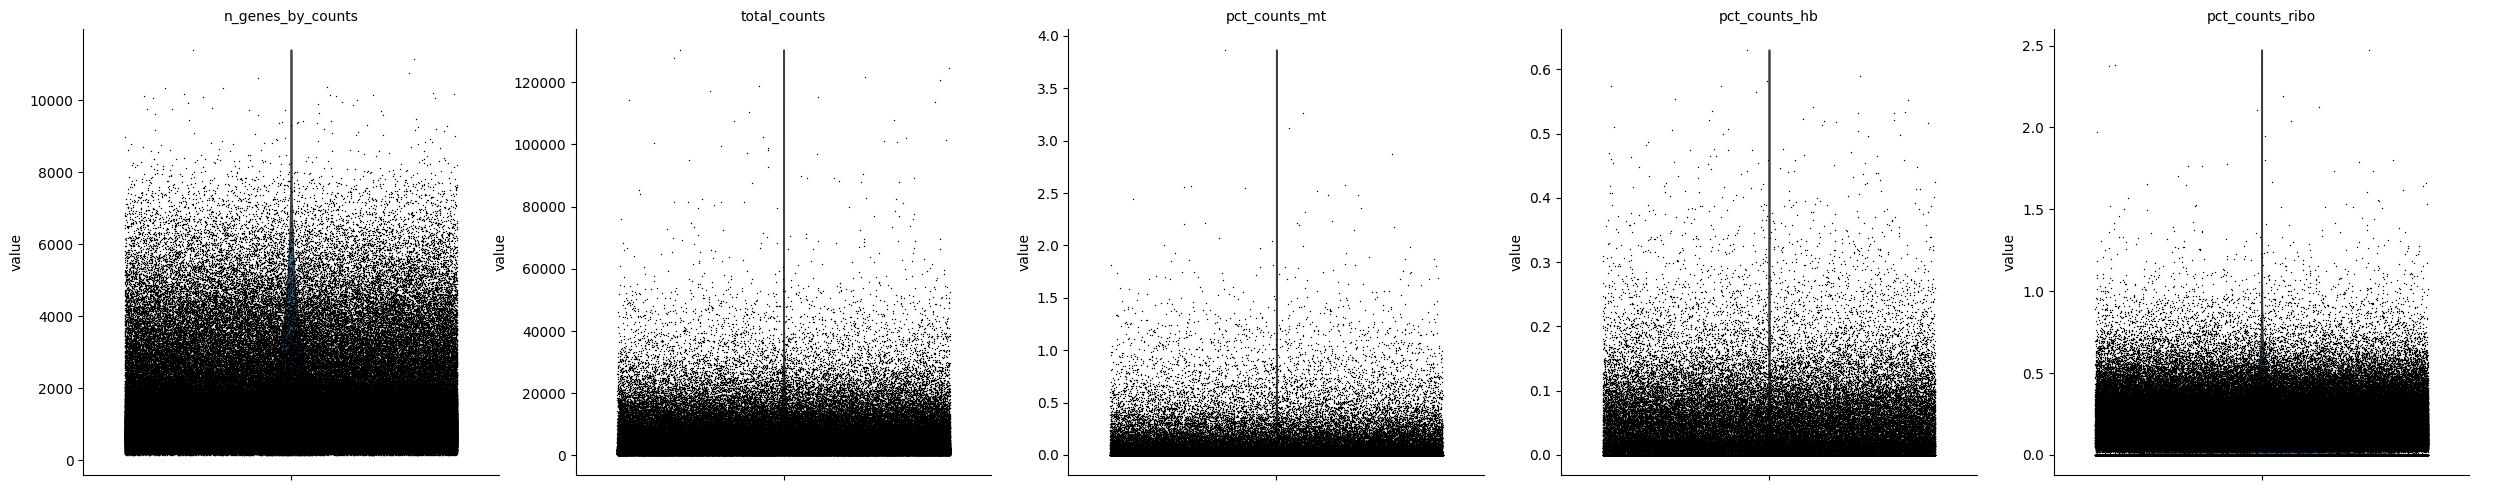

Filtered out 0 cells
CPU times: user 1min 2s, sys: 47 s, total: 1min 49s
Wall time: 37.6 s


In [7]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [8]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 1099 likely doublets
CPU times: user 2h 43min 58s, sys: 3h 30min 18s, total: 6h 14min 17s
Wall time: 1h 2min 22s


2024-10-10 16:00:36,246 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-10 16:01:03,261 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-10 16:01:05,535 - harmonypy - INFO - Iteration 1 of 10
2024-10-10 16:05:24,445 - harmonypy - INFO - Iteration 2 of 10
2024-10-10 16:09:07,752 - harmonypy - INFO - Iteration 3 of 10
2024-10-10 16:12:44,098 - harmonypy - INFO - Iteration 4 of 10
2024-10-10 16:14:04,716 - harmonypy - INFO - Converged after 4 iterations


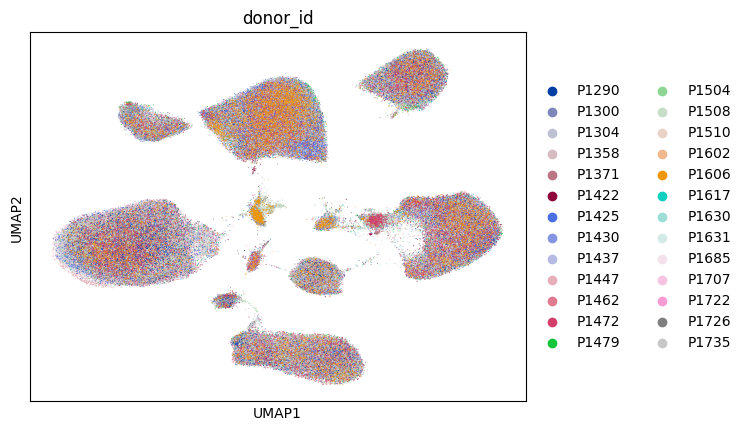

CPU times: user 2h 43min 20s, sys: 4h 29min 32s, total: 7h 12min 52s
Wall time: 26min 18s


In [9]:
%%time
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

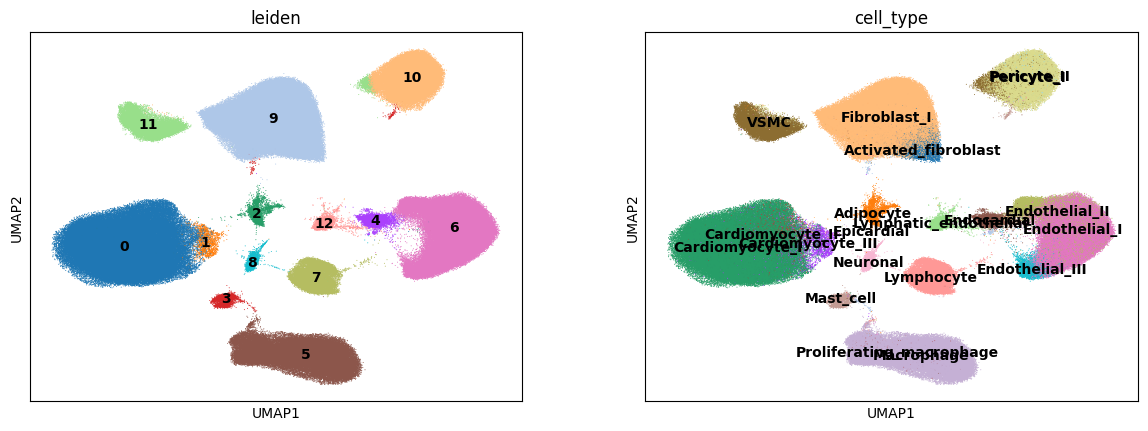

In [10]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

In [11]:
set(adata.obs.cell_type)

{'Activated_fibroblast',
 'Adipocyte',
 'Cardiomyocyte_I',
 'Cardiomyocyte_II',
 'Cardiomyocyte_III',
 'Endocardial',
 'Endothelial_I',
 'Endothelial_II',
 'Endothelial_III',
 'Epicardial',
 'Fibroblast_I',
 'Lymphatic_endothelial',
 'Lymphocyte',
 'Macrophage',
 'Mast_cell',
 'Neuronal',
 'Pericyte_I',
 'Pericyte_II',
 'Proliferating_macrophage',
 'VSMC'}

In [12]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "Adipocyte": "Adipocyte",
        "Activated_fibroblast": "Fibroblast",
        "Cardiomyocyte_I": "Cardiomyocyte",
        "Cardiomyocyte_II": "Cardiomyocyte",
        "Cardiomyocyte_III": "Cardiomyocyte",
        "Endocardial": "Endocardial",
        "Endothelial_I": "Endothelial",
        "Endothelial_II": "Endothelial",
        "Endothelial_III": "Endothelial",
        "Fibroblast_I": "Fibroblast",
        "Fibroblast_II": "Fibroblast",
        "Activated_fibroblast": "Fibroblast",
        "Epicardial": "Epicardial",
        "Pericyte_I": "Pericyte",
        "Pericyte_II": "Pericyte",
        "Macrophage": "Myeloid",
        "Proliferating_macrophage": "Myeloid",
        "Mast_cell": "Mast",
        "Neuronal": "Neuronal",
        "Lymphatic_endothelial": "LEC",
        "VSMC": "vSMC",
        "Lymphocyte": "Lymphoid",
    }
)

In [13]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'LEC',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMC'}

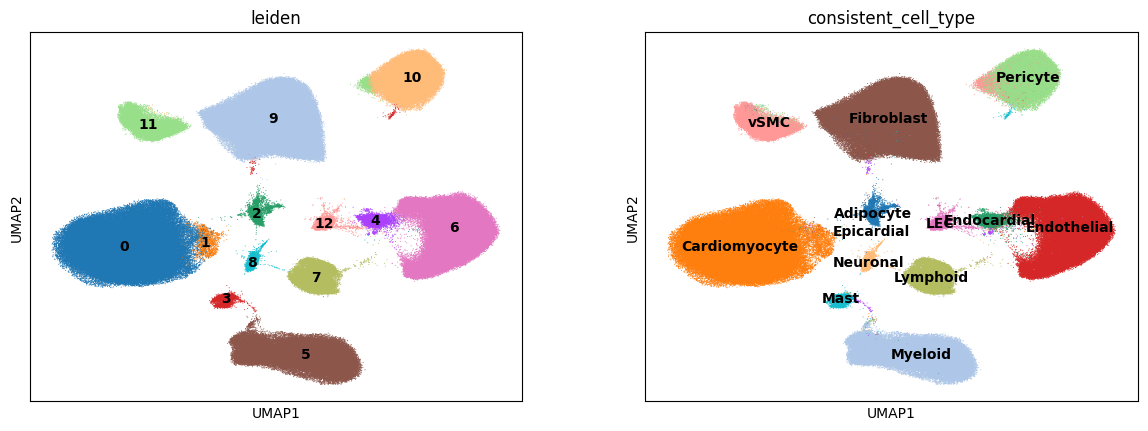

In [14]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [15]:
adata.write("processed_Chaffin_diseased.h5ad")